In [2]:
import requests
import pandas as pd 
import numpy as np
import re
import sys, getopt
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

def load_csv_dataset(file_path):
    return pd.read_csv(file_path)


In [3]:
os.chdir('/Users/finneganlaister-smith/Downloads/DEV ENVIRONMENT/data-science-jupyter-template-main/footy_project_market_value_rankings')

os.getcwd()

'/Users/finneganlaister-smith/Downloads/DEV ENVIRONMENT/data-science-jupyter-template-main/footy_project_market_value_rankings'

In [9]:
latest_match_data = load_csv_dataset('Analysis_Q1/latest_match_data_june_18_SUPERSTAR_INFO_ADDED.csv')
latest_match_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
pd.set_option('display.max_columns', None)

In [11]:
matches_uefa_vs_not = latest_match_data[
    ((latest_match_data['Team.1.Confederation'] == 'UEFA') & (latest_match_data['Team.2.Confederation'] != 'UEFA')) |
    ((latest_match_data['Team.2.Confederation'] == 'UEFA') & (latest_match_data['Team.1.Confederation'] != 'UEFA'))
]

In [21]:
matches_uefa_vs_uefa = latest_match_data[
    ((latest_match_data['Team.1.Confederation'] == 'UEFA') & (latest_match_data['Team.2.Confederation'] == 'UEFA')) |
    ((latest_match_data['Team.2.Confederation'] == 'UEFA') & (latest_match_data['Team.1.Confederation'] == 'UEFA'))
]

In [23]:
matches_uefa_vs_uefa.to_csv('uefa_teams_vs_uefa_teams_match_data.csv')

In [20]:
matches_uefa_vs_not.to_csv('uefa_teams_vs_non_uefa_teams_match_data.csv')

In [24]:
matches_uefa_vs_not_olympics = matches_uefa_vs_not[matches_uefa_vs_not['Competition'] == 'Olympics']
matches_uefa_vs_not_wc = matches_uefa_vs_not[matches_uefa_vs_not['Competition'] != 'Olympics']


## PLOT FUNCTIONS

In [46]:
def plot_competition_data(subset, competition_name):
    # Drop rows with NaN values in 'average_mv_prediction_correct'
    subset = subset.dropna(subset=['average_mv_prediction_correct'])
    
    plt.figure(figsize=(10, 6))
    
    # Create the plot
    plot = sns.lineplot(data=subset, x='interval', y='average_mv_prediction_correct', alpha=0.7)
    
    # Highlight vertical bars where Y value is at or above 0.75
    for _, row in subset.iterrows():
        if row['average_mv_prediction_correct'] >= 0.75:
            plt.axvspan(row['interval'] - 0.1, row['interval'] + 0.1, color='lightpink', alpha=0.3)
    
    # Add scatter plot with conditional coloring
    scatter = sns.scatterplot(
        data=subset, 
        x='interval', 
        y='average_mv_prediction_correct', 
        size='sample_size', 
        legend=False, 
        sizes=(20, 200),
        hue=subset['average_mv_prediction_correct'] >= 0.75,  # Conditional coloring
        palette={True: 'red', False: 'blue'}  # Colors for the condition
    )
    
    # Calculate the maximum sample size
    max_sample_size = subset['sample_size'].max()
    
    # Add text annotations for sample size with much larger intervals
    last_annotation_index = -np.inf
    smallest_sample_sizes = subset.nsmallest(5, 'sample_size')
    for i, row in subset.iterrows():
        # Calculate the interval based on a much larger base interval
        interval = int(3000 / (1 + 2 * np.log1p(row['average_mv_prediction_correct'])))
        
        # Adjust interval based on sample size with multiple thresholds
        if row['sample_size'] < 0.5 * max_sample_size:
            interval *= 2  # Increase the interval when sample size is less than 50% of the max sample size
        if row['sample_size'] < 0.2 * max_sample_size:
            interval *= 2  # Further increase the interval when sample size is less than 20% of the max sample size
        if row['sample_size'] < 0.1 * max_sample_size:
            interval *= 2  # Further increase the interval when sample size is less than 10% of the max sample size
        
        if i - last_annotation_index >= interval or row['sample_size'] in smallest_sample_sizes['sample_size'].values:
            plt.text(row['interval'], row['average_mv_prediction_correct'] + 0.1, f'{int(row["sample_size"])}',
                     horizontalalignment='center', size='small', color='black', weight='semibold', rotation=90)
            last_annotation_index = i
    
    # Add a legend for the sample size text
    plt.text(0.05, 0.95, 'Sample Size', horizontalalignment='left', verticalalignment='top', 
             transform=plt.gca().transAxes, size='medium', color='black', weight='semibold', rotation=0)
    
    # Find the highest X value
    max_x_value = subset['interval'].max()
    max_x_row = subset[subset['interval'] == max_x_value].iloc[0]
    max_x_y_value = max_x_row['average_mv_prediction_correct']
    
    # Add text annotation for the highest X value
    plt.text(max_x_value, max_x_y_value, f'Highest X: {max_x_value}', 
             horizontalalignment='right', size='medium', color='red', weight='semibold')
    
    # Set X axis to a logarithmic scale
    plt.xscale('log')
    
    # Set Y axis limits
    plt.ylim(0, 1)
    
    # Add more Y axis ticks
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    # Add labels and title
    plt.title(f"% of correctly predicted matches by difference in market value, {competition_name}", pad=20, loc='left')
    plt.xlabel("Interval (log scale)")
    plt.ylabel("Average MV Prediction Correct")
    
    # Use a minimal theme
    sns.despine()
    
    # Display the plot
    plt.show()
    
    # Clear the current plot to free memory
    plt.clf()

In [38]:
def plot_competition_data_below(subset, competition_name, annotation_interval=20, secondary_annotation_interval=40):
    # Drop rows with NaN values in 'average_mv_prediction_correct'
    subset = subset.dropna(subset=['average_mv_prediction_correct'])
    
    plt.figure(figsize=(10, 6))
    
    # Create the plot
    plot = sns.lineplot(data=subset, x='interval', y='average_mv_prediction_correct', alpha=0.7)
    
    # Highlight vertical bars where Y value is at or above 0.75
    for _, row in subset.iterrows():
        if row['average_mv_prediction_correct'] >= 0.75:
            plt.axvspan(row['interval'] - 0.1, row['interval'] + 0.1, color='pink', alpha=0.3)
        # Highlight areas where Y value is below 0.3
        if row['average_mv_prediction_correct'] < 0.3:
            plt.axvspan(row['interval'] - 0.1, row['interval'] + 0.1, color='lightpink', alpha=0.5)
    
    # Add scatter plot with conditional coloring
    scatter = sns.scatterplot(
        data=subset, 
        x='interval', 
        y='average_mv_prediction_correct', 
        size='sample_size', 
        legend=False, 
        sizes=(20, 200),
        hue=subset['average_mv_prediction_correct'] <= 0.3,  # Conditional coloring
        palette={True: 'red', False: 'blue'}  # Colors for the condition
    )
    
    # Calculate the maximum sample size
    max_sample_size = subset['sample_size'].max()
    threshold_sample_size_low = 0.1 * max_sample_size  # 10% of the maximum sample size
    secondary_threshold_sample_size = 0.05 * max_sample_size  # 5% of the maximum sample size
    
    # Initialize the last annotated sample size and last annotated index
    last_annotation_index = -annotation_interval  # Ensure the first point can be annotated
    last_secondary_annotation_index = -secondary_annotation_interval  # For secondary threshold
    last_annotated_sample_size = None  # For tracking changes in sample size
    
    # Add text annotations for points where sample size is below 10% of the maximum
    for i, row in subset.iterrows():
        if row['sample_size'] < threshold_sample_size_low:
            if row['sample_size'] >= secondary_threshold_sample_size:
                # Annotate only if the sample size changes by at least 3
                if last_annotated_sample_size is None or abs(row['sample_size'] - last_annotated_sample_size) >= 3:
                    if i - last_secondary_annotation_index >= secondary_annotation_interval:
                        plt.text(row['interval'], row['average_mv_prediction_correct'] + 0.05, f'{int(row["sample_size"])}',
                                 horizontalalignment='center', size='small', color='black', weight='semibold', rotation=90)
                        last_secondary_annotation_index = i
                        last_annotated_sample_size = row['sample_size']
            else:
                if i - last_annotation_index >= annotation_interval:
                    plt.text(row['interval'], row['average_mv_prediction_correct'] + 0.05, f'{int(row["sample_size"])}',
                             horizontalalignment='center', size='small', color='black', weight='semibold', rotation=90)
                    last_annotation_index = i
    
    # Add annotation for sample size exactly at 10% of the maximum or the closest one
    ten_percent_sample_size = threshold_sample_size_low
    ten_percent_row = subset.iloc[(subset['sample_size'] - ten_percent_sample_size).abs().argsort()[:1]]
    if not ten_percent_row.empty:
        row = ten_percent_row.iloc[0]
        plt.text(row['interval'], row['average_mv_prediction_correct'] + 0.05, f'10% Max: {int(row["sample_size"])}',
                 horizontalalignment='center', size='small', color='purple', weight='semibold', rotation=90)

    # Find the lowest X value
    min_x_value = subset['interval'].min()
    min_x_row = subset[subset['interval'] == min_x_value].iloc[0]
    min_x_y_value = min_x_row['average_mv_prediction_correct']
    
    # Add text annotation for the lowest X value, moved down and to the left
    plt.text(min_x_value, min_x_y_value - 0.05, f'Lowest X: {min_x_value}', 
             horizontalalignment='left', size='medium', color='red', weight='semibold')
    
    # Annotate the point where sample_size first reaches the maximum value
    max_sample_size_row = subset[subset['sample_size'] == max_sample_size].iloc[0]
    plt.text(max_sample_size_row['interval'], max_sample_size_row['average_mv_prediction_correct'] + 0.05, 
             f'Max Sample Size: {int(max_sample_size_row["sample_size"])}', 
             horizontalalignment='center', size='medium', color='green', weight='semibold')
    
    # Set X axis to a logarithmic scale
    plt.xscale('log')
    
    # Set Y axis limits
    plt.ylim(0, 1)
    
    # Add more Y axis ticks
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    # Add labels and title
    plt.title(f"% of correctly predicted matches by difference in market value, {competition_name}", pad=20, loc='left')
    plt.xlabel("Interval (log scale)")
    plt.ylabel("Average MV Prediction Correct")
    
    # Use a minimal theme
    sns.despine()
    
    # Display the plot
    plt.show()
    
    # Clear the current plot to free memory
    plt.clf()

## UEFA vs UEFA

In [35]:
uefa_vs_uefa_intervals_above = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs UEFA/uefa_vs_uefa_ABOVE_INTERVALS.csv')
uefa_vs_uefa_intervals_below = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs UEFA/uefa_vs_uefa_BELOW_INTERVALS.csv')

### ABOVE INTERVALS


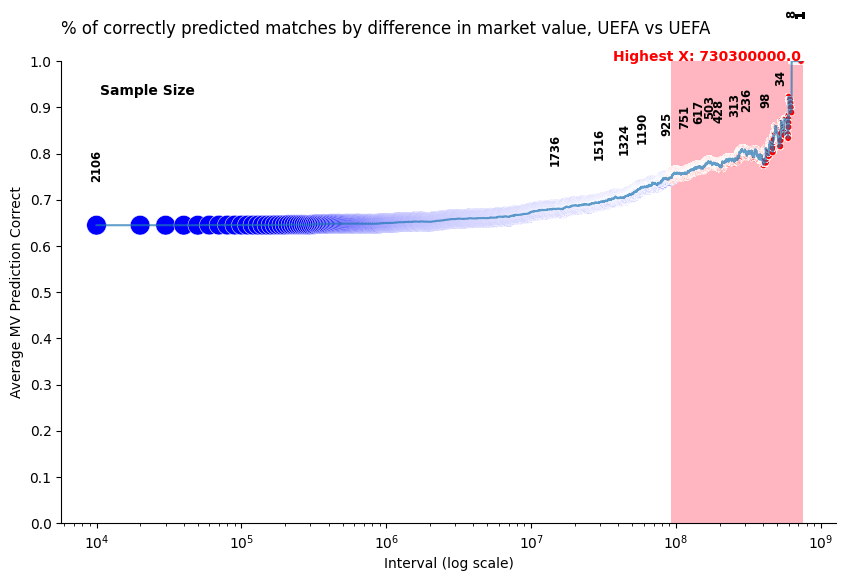

<Figure size 640x480 with 0 Axes>

In [47]:
plot_competition_data(uefa_vs_uefa_intervals_above, 'UEFA vs UEFA')

### BELOW INTERVALS

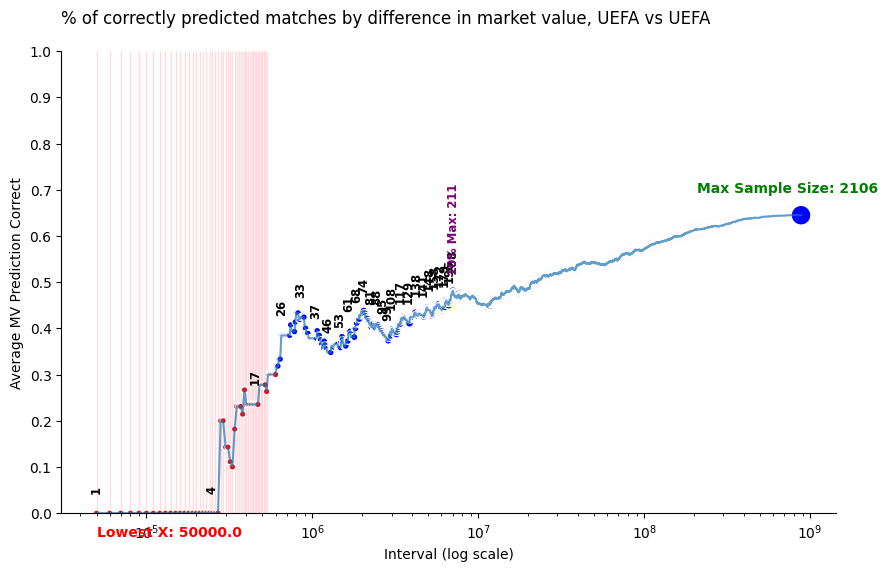

<Figure size 640x480 with 0 Axes>

In [48]:
plot_competition_data_below(uefa_vs_uefa_intervals_below, 'UEFA vs UEFA')

## UEFA vs NON-UEFA - WC

In [50]:
uefa_vs_not_uefa_wc_above_intervals = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs NOT UEFA - WC/uefa_vs_not_uefa_wc_ABOVE_INTERVALS.csv')
uefa_vs_not_uefa_wc_below_intervals = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs NOT UEFA - WC/uefa_vs_not_uefa_wc_BELOW_INTERVALS.csv')

### Above Intervals

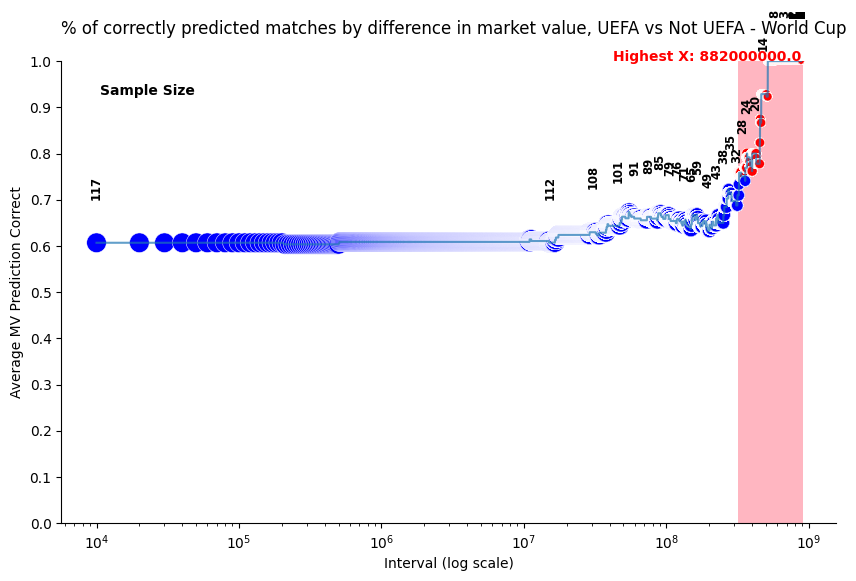

<Figure size 640x480 with 0 Axes>

In [51]:
plot_competition_data(uefa_vs_not_uefa_wc_above_intervals, 'UEFA vs Not UEFA - World Cup')

### Below Intervals

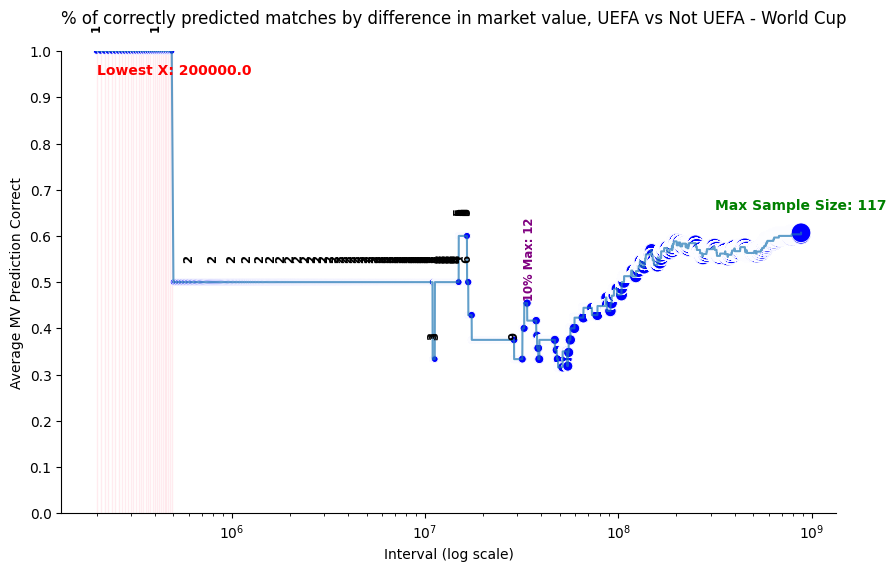

<Figure size 640x480 with 0 Axes>

In [52]:
plot_competition_data_below(uefa_vs_not_uefa_wc_below_intervals, 'UEFA vs Not UEFA - World Cup')

## UEFA vs NON-UEFA - OLYMPICS

In [53]:
uefa_vs_not_uefa_olympics_above_intervals = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs NOT UEFA - OLYMPICS/uefa_vs_not_uefa_OLYMPICS_ABOVE_INTERVALS.csv')
uefa_vs_not_uefa_olympics_below_intervals = load_csv_dataset('Analysis_Q1/UEFA vs UEFA-NOT UEFA/UEFA vs NOT UEFA - OLYMPICS/uefa_vs_not_uefa_OLYMPICS_BELOW_INTERVALS.csv')

### Above Intervals

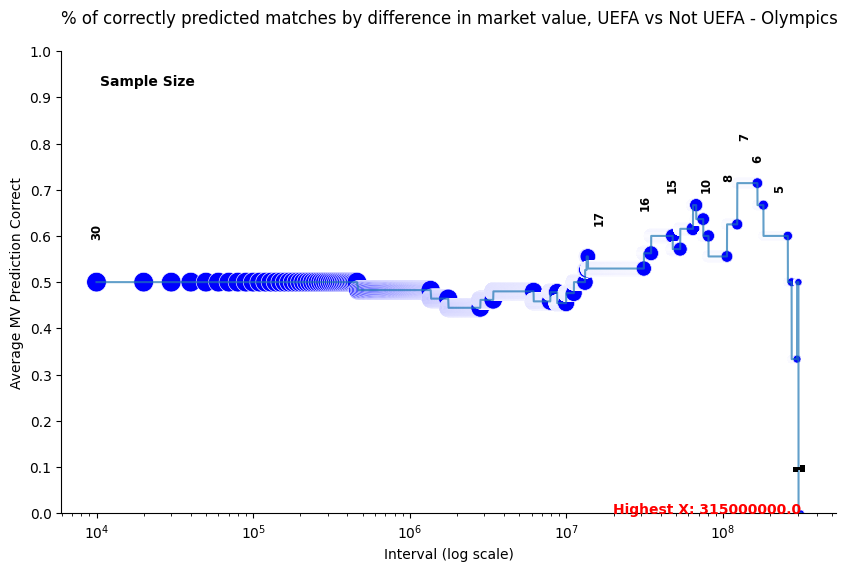

<Figure size 640x480 with 0 Axes>

In [54]:
plot_competition_data(uefa_vs_not_uefa_olympics_above_intervals, 'UEFA vs Not UEFA - Olympics')

### Below Intervals

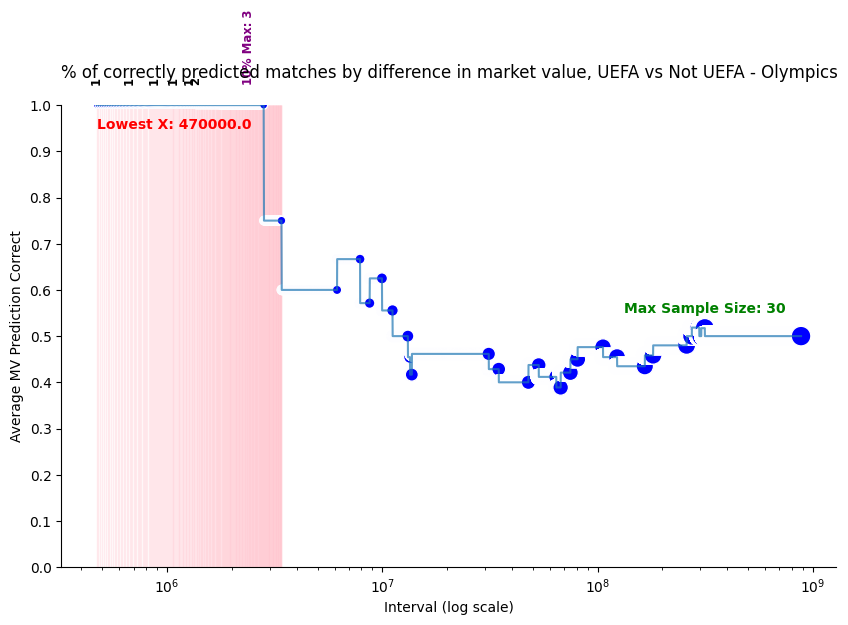

<Figure size 640x480 with 0 Axes>

In [55]:
plot_competition_data_below(uefa_vs_not_uefa_olympics_below_intervals, 'UEFA vs Not UEFA - Olympics')